In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import Dataset, DataLoader


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Define the amino acid alphabet
AMINO_ACIDS = 'ACDEFGHIKLMNPQRSTVWY'
AA_TO_IDX = {aa: idx for idx, aa in enumerate(AMINO_ACIDS)}
IDX_TO_AA = {idx: aa for idx, aa in enumerate(AMINO_ACIDS)}

class ProteinDataset(Dataset):
    """
    Custom dataset class for protein sequences and their properties.
    
    This class handles the conversion from amino acid sequences to numerical
    representations and manages the relationship between sequences and their
    target properties.
    """
    
    def __init__(self, sequences, targets, max_length=500):
        # If sequences/targets are pandas Series – drop old index and convert
        if isinstance(sequences, pd.Series):
            sequences = sequences.reset_index(drop=True).tolist()
        if isinstance(targets, pd.Series):
            targets = targets.reset_index(drop=True).tolist()

        self.sequences = sequences          # now a simple Python list
        self.targets   = targets            # plain list as well
        self.max_length = max_length

        # Normalise targets
        self.target_scaler = StandardScaler()
        self.normalized_targets = self.target_scaler.fit_transform(
            np.array(self.targets).reshape(-1, 1)
        ).flatten()

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        sequence = self.sequences[idx]
        target   = self.normalized_targets[idx]

        sequence_tensor = self.sequence_to_tensor(sequence)
        target_tensor   = torch.tensor(target, dtype=torch.float32)
        return sequence_tensor, target_tensor
    
    def sequence_to_tensor(self, sequence):
        """
        Convert a protein sequence string to a one-hot encoded tensor.
        
        This function handles padding and truncation to ensure all sequences
        have the same length.
        """
        # Truncate if too long
        if len(sequence) > self.max_length:
            sequence = sequence[:self.max_length]
        
        # Create one-hot encoding
        tensor = torch.zeros(self.max_length, len(AMINO_ACIDS))
        
        for i, aa in enumerate(sequence):
            if aa in AA_TO_IDX:
                tensor[i, AA_TO_IDX[aa]] = 1.0
        
        return tensor
    
    def denormalize_target(self, normalized_value):
        """
        Convert normalized target back to original scale.
        
        This is useful for interpreting model predictions.
        """
        return self.target_scaler.inverse_transform([[normalized_value]])[0][0]

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ProteinCNN(nn.Module):
    """
    An intermediate CNN that balances complexity and regularization.
    - Restores one deeper convolutional layer to capture hierarchical patterns.
    - Uses a moderately sized fully-connected head.
    """ 

    def __init__(self, num_amino_acids=21, embedding_dim=64, num_filters=96, dropout_rate=0.4):
        """
        Initialize the intermediate CNN architecture.
        
        Args:
            num_amino_acids: Vocabulary size (e.g., 20 + 1 for padding).
            embedding_dim: Size of the learned embedding vector.
            num_filters: Number of filters. Increased slightly to 96 to give more capacity.
            dropout_rate: A more moderate dropout rate.
        """
        super(ProteinCNN, self).__init__()

        self.embedding = nn.Embedding(num_embeddings=num_amino_acids, embedding_dim=embedding_dim)

        # First block of convolutions with different kernel sizes
        self.conv1 = nn.Conv1d(embedding_dim, num_filters, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(embedding_dim, num_filters, kernel_size=5, padding=2)
        self.conv3 = nn.Conv1d(embedding_dim, num_filters, kernel_size=7, padding=3)

        self.batch_norm1 = nn.BatchNorm1d(num_filters)
        self.batch_norm2 = nn.BatchNorm1d(num_filters)
        self.batch_norm3 = nn.BatchNorm1d(num_filters)

        # --- RESTORED a deeper convolutional layer ---
        # This allows the model to learn combinations of the initial motifs.
        # It takes the concatenated output (num_filters * 3) as input.
        self.conv4 = nn.Conv1d(num_filters * 3, num_filters * 2, kernel_size=3, padding=1)
        self.batch_norm4 = nn.BatchNorm1d(num_filters * 2)
        
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        
        # --- FC head is more powerful than before, but simpler than original ---
        # The input is from conv4, which has num_filters * 2 channels.
        self.fc1 = nn.Linear(num_filters * 2, 256) 
        self.fc_out = nn.Linear(256, 1)
        
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x_one_hot):
        """
        Forward pass.
        
        Args:
            x_one_hot: Input tensor of one-hot vectors [batch, seq_len, num_amino_acids]
        """
        # Convert one-hot to indices on the fly
        x_indices = torch.argmax(x_one_hot, dim=2)
        
        x = self.embedding(x_indices)
        x = x.transpose(1, 2)
        
        # First conv block
        conv1_out = F.relu(self.batch_norm1(self.conv1(x)))
        conv2_out = F.relu(self.batch_norm2(self.conv2(x)))
        conv3_out = F.relu(self.batch_norm3(self.conv3(x)))
        
        x = torch.cat([conv1_out, conv2_out, conv3_out], dim=1)
        
        # --- Apply the deeper conv layer ---
        x = F.relu(self.batch_norm4(self.conv4(x)))
        x = self.dropout(x) # Apply dropout after the main conv blocks
        
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        
        # FC layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        
        x = self.fc_out(x)
        
        return x

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
from fpgen.prop_prediction.metrics import get_regression_metrics
import time

# Set random seeds for reproducibility
# This ensures that your results are consistent across runs
torch.manual_seed(42)
np.random.seed(42)

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Training on: {device}")

Training on: cuda


In [6]:
import tqdm


def train_cnn_model(model, train_loader, val_loader, num_epochs=100, learning_rate=0.001):
    """
    Train the CNN model with careful monitoring and early stopping.
    
    This function implements best practices for training neural networks on small datasets,
    including learning rate scheduling, early stopping, and comprehensive monitoring.
    """
    print(torch.cuda.device_count())
    torch.cuda.set_device(0)
    # Move model to the appropriate device (GPU if available)
    model = model.to(device)
    # print devices
    
    
    # Choose optimizer and loss function
    # Adam is generally a good choice for CNNs because it adapts the learning rate
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    
    # Mean Squared Error for regression tasks
    criterion = nn.MSELoss()
    
    # Learning rate scheduler - reduces learning rate when validation loss plateaus
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', patience=10, factor=0.5
    )
    
    # Early stopping to prevent overfitting
    best_val_loss = float('inf')
    patience_counter = 0
    early_stopping_patience = 20
    
    # Track training history
    train_losses = []
    val_losses = []
    learning_rates = []
    
    print("Starting training...")
    print(f"Training batches per epoch: {len(train_loader)}")
    print(f"Validation batches per epoch: {len(val_loader)}")
    
    for epoch in tqdm.tqdm(range(num_epochs)):
        # Training phase
        model.train()  # Set model to training mode
        train_loss = 0.0
        train_batches = 0
        for batch_idx, (sequences, targets) in enumerate(train_loader):
            # Move data to device
            sequences = sequences.to(device)
            targets = targets.to(device)

            # Zero the gradients
            optimizer.zero_grad()
            
            # Forward pass
            predictions = model(sequences)
            
            # Calculate loss
            loss = criterion(predictions.squeeze(), targets)
            
            # Backward pass
            loss.backward()
            
            # Gradient clipping to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            # Update parameters
            optimizer.step()
            
            train_loss += loss.item()
            train_batches += 1
            
            # Print progress every 10 batches
            if batch_idx % 10 == 0:
                print(f'Epoch {epoch+1}, Batch {batch_idx}, Loss: {loss.item():.6f}')
        
        # Calculate average training loss
        avg_train_loss = train_loss / train_batches
        
        # Validation phase
        model.eval()  # Set model to evaluation mode
        val_loss = 0.0
        val_batches = 0
        
        with torch.no_grad():  # Disable gradient computation for efficiency
            for sequences, targets in val_loader:
                sequences = sequences.to(device)
                targets = targets.to(device)
                
                predictions = model(sequences)
                loss = criterion(predictions.squeeze(), targets)
                
                val_loss += loss.item()
                val_batches += 1
        
        avg_val_loss = val_loss / val_batches
        
        # Record history
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        learning_rates.append(optimizer.param_groups[0]['lr'])
        
        # Print epoch summary
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'  Train Loss: {avg_train_loss:.6f}')
        print(f'  Val Loss: {avg_val_loss:.6f}')
        print(f'  Learning Rate: {optimizer.param_groups[0]["lr"]:.8f}')
        print('-' * 50)
        
        # Learning rate scheduling
        scheduler.step(avg_val_loss)
        
        # Early stopping check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            # Save the best model
            torch.save(model.state_dict(), 'best_cnn_model.pth')
            print(f'New best model saved with validation loss: {best_val_loss:.6f}')
        else:
            patience_counter += 1
            
        if patience_counter >= early_stopping_patience:
            print(f'Early stopping triggered after {epoch+1} epochs')
            break
    
    # Load the best model
    model.load_state_dict(torch.load('best_cnn_model.pth'))
    
    return model, train_losses, val_losses, learning_rates

In [7]:
def setup_data_loaders(fpbase_dataset, target_name='ex_max', batch_size=32, val_split=0.2):
    """
    Create training and validation data loaders using FPbase's train/test split.
    
    Args:
        fpbase_dataset: Instance of FPbase class
        target_name: Name of the target property (e.g., 'ex_max')
        batch_size: Batch size for DataLoader
        val_split: Fraction of training data to use for validation
    
    Returns:
        train_loader: DataLoader for training data
        val_loader: DataLoader for validation data
        test_loader: DataLoader for test data
        train_dataset: ProteinDataset instance for training data
    """
    
    # Get train and test data from FPbase
    x_train, y_train = fpbase_dataset.get_train(target_name, is_scaled=True)
    x_test, y_test = fpbase_dataset.get_test(target_name, is_scaled=True)
    
    # Create full training dataset
    train_full_dataset = ProteinDataset(x_train, y_train, max_length=500)
    
    # Split training data into train and validation
    total_size = len(train_full_dataset)
    train_size = int((1 - val_split) * total_size)
    val_size = total_size - train_size
    
    print(f"Full training set size: {total_size}")
    print(f"Training set size: {train_size}")
    print(f"Validation set size: {val_size}")
    print(f"Test set size: {len(x_test)}")
    
    # Split training dataset into train and validation
    train_dataset, val_dataset = random_split(
        train_full_dataset, 
        [train_size, val_size],
        generator=torch.Generator().manual_seed(42)  # For reproducibility
    )
    
    # Create test dataset
    test_dataset = ProteinDataset(x_test, y_test, max_length=500)
    
    # Create data loaders
    train_loader = DataLoader(
        train_dataset, 
        batch_size=batch_size, 
        shuffle=True,
        num_workers=0,
        pin_memory=True if torch.cuda.is_available() else False
    )
    
    val_loader = DataLoader(
        val_dataset, 
        batch_size=batch_size, 
        shuffle=False,
        num_workers=0,
        pin_memory=True if torch.cuda.is_available() else False
    )
    
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
        pin_memory=True if torch.cuda.is_available() else False
    )
    
    return train_loader, val_loader, test_loader, train_full_dataset

In [8]:
def evaluate_model(model, data_loader, dataset, fpbase_dataset, target_name='ex_max'):
    """
    Evaluate the trained model and calculate performance metrics.
    
    This function provides comprehensive evaluation including predictions
    on both normalized and original scales using FPbase rescaling.
    
    Args:
        model: The trained model
        data_loader: DataLoader with test/validation data
        dataset: ProteinDataset instance
        fpbase_dataset: FPbase instance for proper rescaling
        target_name: Name of the target property (default: 'ex_max')
    """
    
    model.eval()
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for sequences, targets in data_loader:
            sequences = sequences.to(device)
            targets = targets.to(device)
            
            predictions = model(sequences)
            
            all_predictions.extend(predictions.squeeze().cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
    
    # Convert to numpy arrays
    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)
    
    # Calculate metrics on normalized scale
    metrics_normalized = get_regression_metrics(all_predictions, all_targets)
    
    # Rescale using FPbase for interpretable metrics
    targets_original = fpbase_dataset.rescale_targets(all_targets, target_name)
    predictions_original = fpbase_dataset.rescale_targets(all_predictions, target_name)
    
    # Calculate metrics on original scale
    metrics_original = get_regression_metrics(predictions_original, targets_original)
    
    print("\nModel Evaluation Results:")
    print(f"Normalized metrics:")
    print(f"  R² Score: {metrics_normalized['r2']:.4f}")
    print(f"  RMSE: {metrics_normalized['rmse']:.4f}")
    print(f"  MAE: {metrics_normalized['mae']:.4f}")
    print(f"  Median AE: {metrics_normalized['mae_median']:.4f}")
    
    print(f"\nOriginal scale metrics:")
    print(f"  R² Score: {metrics_original['r2']:.4f}")
    print(f"  RMSE: {metrics_original['rmse']:.4f}")
    print(f"  MAE: {metrics_original['mae']:.4f}")
    print(f"  Median AE: {metrics_original['mae_median']:.4f}")
    
    return {
        'predictions_original': predictions_original,
        'targets_original': targets_original,
        **{f"{k}_original": v for k, v in metrics_original.items()},
        **{f"{k}_normalized": v for k, v in metrics_normalized.items()}
    }

def plot_training_history(train_losses, val_losses, learning_rates):
    """
    Visualize the training process to understand model behavior.
    
    These plots help you understand whether your model is learning properly,
    overfitting, or if you need to adjust hyperparameters.
    """
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot training and validation losses
    axes[0, 0].plot(train_losses, label='Training Loss', color='blue')
    axes[0, 0].plot(val_losses, label='Validation Loss', color='red')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].set_title('Training and Validation Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True)
    
    # Plot learning rate schedule
    axes[0, 1].plot(learning_rates, color='green')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Learning Rate')
    axes[0, 1].set_title('Learning Rate Schedule')
    axes[0, 1].set_yscale('log')
    axes[0, 1].grid(True)
    
    # Plot loss difference (overfitting indicator)
    loss_diff = np.array(val_losses) - np.array(train_losses)
    axes[1, 0].plot(loss_diff, color='purple')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Validation Loss - Training Loss')
    axes[1, 0].set_title('Overfitting Indicator')
    axes[1, 0].axhline(y=0, color='black', linestyle='--', alpha=0.5)
    axes[1, 0].grid(True)
    
    # Plot validation loss with trend
    axes[1, 1].plot(val_losses, color='red', alpha=0.7)
    # Add trend line
    z = np.polyfit(range(len(val_losses)), val_losses, 1)
    p = np.poly1d(z)
    axes[1, 1].plot(range(len(val_losses)), p(range(len(val_losses))), 
                   color='black', linestyle='--', label='Trend')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Validation Loss')
    axes[1, 1].set_title('Validation Loss with Trend')
    axes[1, 1].legend()
    axes[1, 1].grid(True)
    
    plt.tight_layout()
    plt.show()

In [9]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

In [10]:
# Initialize FPbase dataset
from fpgen.prop_prediction.dataset import FPbase
dataset = FPbase()

# Create data loaders using FPbase's train/test split
batch_size = 32
train_loader, val_loader, test_loader, train_dataset = setup_data_loaders(
    fpbase_dataset=dataset,
    target_name='ex_max',
    batch_size=batch_size,
    val_split=0.2  # 20% of training data for validation
)

Full training set size: 676
Training set size: 540
Validation set size: 136
Test set size: 173


In [11]:
import torch
print("CUDA available :", torch.cuda.is_available())
print("GPU count       :", torch.cuda.device_count())
for i in range(torch.cuda.device_count()):
    print(f"GPU {i} name     :", torch.cuda.get_device_name(i))
    print(f"GPU {i} capability:",
          torch.cuda.get_device_capability(i))

CUDA available : True
GPU count       : 1
GPU 0 name     : NVIDIA GeForce RTX 4050 Laptop GPU
GPU 0 capability: (8, 9)


In [12]:
# Initialize model
model = ProteinCNN(
    num_amino_acids=20,  # Standard amino acids
    num_filters=128,
    dropout_rate=0.5
).to(device)

# Train model
print("Starting training...")
trained_model, train_losses, val_losses, learning_rates = train_cnn_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=200,
    learning_rate=0.001
)

Starting training...
1
Starting training...
Training batches per epoch: 17
Validation batches per epoch: 5


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1, Batch 0, Loss: 0.926573
Epoch 1, Batch 10, Loss: 0.658266


  0%|          | 1/200 [00:01<06:21,  1.92s/it]

Epoch 1/200:
  Train Loss: 1.040372
  Val Loss: 0.759118
  Learning Rate: 0.00100000
--------------------------------------------------
New best model saved with validation loss: 0.759118
Epoch 2, Batch 0, Loss: 0.750104
Epoch 2, Batch 10, Loss: 0.817450


  1%|          | 2/200 [00:02<04:13,  1.28s/it]

Epoch 2/200:
  Train Loss: 0.745727
  Val Loss: 0.685618
  Learning Rate: 0.00100000
--------------------------------------------------
New best model saved with validation loss: 0.685618
Epoch 3, Batch 0, Loss: 0.461182
Epoch 3, Batch 10, Loss: 1.136249


  2%|▏         | 3/200 [00:03<03:28,  1.06s/it]

Epoch 3/200:
  Train Loss: 0.649153
  Val Loss: 0.425615
  Learning Rate: 0.00100000
--------------------------------------------------
New best model saved with validation loss: 0.425615
Epoch 4, Batch 0, Loss: 0.738198
Epoch 4, Batch 10, Loss: 0.650467


  2%|▏         | 4/200 [00:04<03:09,  1.03it/s]

Epoch 4/200:
  Train Loss: 0.655219
  Val Loss: 0.691698
  Learning Rate: 0.00100000
--------------------------------------------------
Epoch 5, Batch 0, Loss: 0.479222
Epoch 5, Batch 10, Loss: 0.833914


  2%|▎         | 5/200 [00:05<03:01,  1.07it/s]

Epoch 5/200:
  Train Loss: 0.590800
  Val Loss: 1.285917
  Learning Rate: 0.00100000
--------------------------------------------------
Epoch 6, Batch 0, Loss: 0.410606
Epoch 6, Batch 10, Loss: 0.753939


  3%|▎         | 6/200 [00:06<02:59,  1.08it/s]

Epoch 6/200:
  Train Loss: 0.581698
  Val Loss: 0.419301
  Learning Rate: 0.00100000
--------------------------------------------------
New best model saved with validation loss: 0.419301
Epoch 7, Batch 0, Loss: 0.215523
Epoch 7, Batch 10, Loss: 0.705717


  4%|▎         | 7/200 [00:07<02:56,  1.09it/s]

Epoch 7/200:
  Train Loss: 0.554229
  Val Loss: 1.976931
  Learning Rate: 0.00100000
--------------------------------------------------
Epoch 8, Batch 0, Loss: 0.452293
Epoch 8, Batch 10, Loss: 0.473966


  4%|▍         | 8/200 [00:07<02:55,  1.10it/s]

Epoch 8/200:
  Train Loss: 0.534412
  Val Loss: 0.451979
  Learning Rate: 0.00100000
--------------------------------------------------
Epoch 9, Batch 0, Loss: 0.565225
Epoch 9, Batch 10, Loss: 0.779047


  4%|▍         | 9/200 [00:08<02:56,  1.08it/s]

Epoch 9/200:
  Train Loss: 0.571721
  Val Loss: 8.266220
  Learning Rate: 0.00100000
--------------------------------------------------
Epoch 10, Batch 0, Loss: 0.241625
Epoch 10, Batch 10, Loss: 0.639315


  5%|▌         | 10/200 [00:09<02:58,  1.06it/s]

Epoch 10/200:
  Train Loss: 0.504689
  Val Loss: 0.505750
  Learning Rate: 0.00100000
--------------------------------------------------
Epoch 11, Batch 0, Loss: 0.403091
Epoch 11, Batch 10, Loss: 0.522792


  6%|▌         | 11/200 [00:10<02:58,  1.06it/s]

Epoch 11/200:
  Train Loss: 0.536743
  Val Loss: 0.671214
  Learning Rate: 0.00100000
--------------------------------------------------
Epoch 12, Batch 0, Loss: 0.447171
Epoch 12, Batch 10, Loss: 0.469614


  6%|▌         | 12/200 [00:11<02:55,  1.07it/s]

Epoch 12/200:
  Train Loss: 0.460037
  Val Loss: 0.759633
  Learning Rate: 0.00100000
--------------------------------------------------
Epoch 13, Batch 0, Loss: 0.526719
Epoch 13, Batch 10, Loss: 0.343580


  6%|▋         | 13/200 [00:12<02:52,  1.08it/s]

Epoch 13/200:
  Train Loss: 0.454736
  Val Loss: 0.671374
  Learning Rate: 0.00100000
--------------------------------------------------
Epoch 14, Batch 0, Loss: 0.351856
Epoch 14, Batch 10, Loss: 0.372633


  7%|▋         | 14/200 [00:13<02:49,  1.10it/s]

Epoch 14/200:
  Train Loss: 0.462788
  Val Loss: 0.508944
  Learning Rate: 0.00100000
--------------------------------------------------
Epoch 15, Batch 0, Loss: 0.201379
Epoch 15, Batch 10, Loss: 0.452548


  8%|▊         | 15/200 [00:14<02:47,  1.11it/s]

Epoch 15/200:
  Train Loss: 0.515147
  Val Loss: 1.457157
  Learning Rate: 0.00100000
--------------------------------------------------
Epoch 16, Batch 0, Loss: 0.449747
Epoch 16, Batch 10, Loss: 0.279399


  8%|▊         | 16/200 [00:15<02:45,  1.11it/s]

Epoch 16/200:
  Train Loss: 0.404714
  Val Loss: 0.583375
  Learning Rate: 0.00100000
--------------------------------------------------
Epoch 17, Batch 0, Loss: 0.497776
Epoch 17, Batch 10, Loss: 0.396899


  8%|▊         | 17/200 [00:16<02:43,  1.12it/s]

Epoch 17/200:
  Train Loss: 0.392472
  Val Loss: 1.159167
  Learning Rate: 0.00100000
--------------------------------------------------
Epoch 18, Batch 0, Loss: 0.240905
Epoch 18, Batch 10, Loss: 0.500209


  9%|▉         | 18/200 [00:17<02:45,  1.10it/s]

Epoch 18/200:
  Train Loss: 0.402836
  Val Loss: 0.748838
  Learning Rate: 0.00050000
--------------------------------------------------
Epoch 19, Batch 0, Loss: 0.322147
Epoch 19, Batch 10, Loss: 0.305151


 10%|▉         | 19/200 [00:18<02:43,  1.10it/s]

Epoch 19/200:
  Train Loss: 0.389387
  Val Loss: 0.374301
  Learning Rate: 0.00050000
--------------------------------------------------
New best model saved with validation loss: 0.374301
Epoch 20, Batch 0, Loss: 0.231793
Epoch 20, Batch 10, Loss: 0.425002


 10%|█         | 20/200 [00:18<02:42,  1.10it/s]

Epoch 20/200:
  Train Loss: 0.369600
  Val Loss: 0.389513
  Learning Rate: 0.00050000
--------------------------------------------------
Epoch 21, Batch 0, Loss: 0.930994
Epoch 21, Batch 10, Loss: 0.256456


 10%|█         | 21/200 [00:19<02:44,  1.09it/s]

Epoch 21/200:
  Train Loss: 0.388113
  Val Loss: 0.347452
  Learning Rate: 0.00050000
--------------------------------------------------
New best model saved with validation loss: 0.347452
Epoch 22, Batch 0, Loss: 0.338008
Epoch 22, Batch 10, Loss: 0.461523


 11%|█         | 22/200 [00:20<02:44,  1.08it/s]

Epoch 22/200:
  Train Loss: 0.385235
  Val Loss: 0.352052
  Learning Rate: 0.00050000
--------------------------------------------------
Epoch 23, Batch 0, Loss: 0.404553
Epoch 23, Batch 10, Loss: 0.180001


 12%|█▏        | 23/200 [00:21<02:42,  1.09it/s]

Epoch 23/200:
  Train Loss: 0.316213
  Val Loss: 0.329393
  Learning Rate: 0.00050000
--------------------------------------------------
New best model saved with validation loss: 0.329393
Epoch 24, Batch 0, Loss: 0.290219
Epoch 24, Batch 10, Loss: 0.352533


 12%|█▏        | 24/200 [00:22<02:39,  1.10it/s]

Epoch 24/200:
  Train Loss: 0.335339
  Val Loss: 0.556488
  Learning Rate: 0.00050000
--------------------------------------------------
Epoch 25, Batch 0, Loss: 0.295020
Epoch 25, Batch 10, Loss: 0.240271


 12%|█▎        | 25/200 [00:23<02:39,  1.10it/s]

Epoch 25/200:
  Train Loss: 0.292212
  Val Loss: 1.120354
  Learning Rate: 0.00050000
--------------------------------------------------
Epoch 26, Batch 0, Loss: 0.442096
Epoch 26, Batch 10, Loss: 0.280195


 13%|█▎        | 26/200 [00:24<02:45,  1.05it/s]

Epoch 26/200:
  Train Loss: 0.278857
  Val Loss: 0.469577
  Learning Rate: 0.00050000
--------------------------------------------------
Epoch 27, Batch 0, Loss: 0.742764
Epoch 27, Batch 10, Loss: 0.613273


 14%|█▎        | 27/200 [00:25<02:47,  1.03it/s]

Epoch 27/200:
  Train Loss: 0.357085
  Val Loss: 0.310453
  Learning Rate: 0.00050000
--------------------------------------------------
New best model saved with validation loss: 0.310453
Epoch 28, Batch 0, Loss: 0.312912
Epoch 28, Batch 10, Loss: 0.308542


 14%|█▍        | 28/200 [00:26<02:47,  1.02it/s]

Epoch 28/200:
  Train Loss: 0.295954
  Val Loss: 0.448265
  Learning Rate: 0.00050000
--------------------------------------------------
Epoch 29, Batch 0, Loss: 0.367869
Epoch 29, Batch 10, Loss: 0.242434


 14%|█▍        | 29/200 [00:27<02:47,  1.02it/s]

Epoch 29/200:
  Train Loss: 0.316615
  Val Loss: 0.324280
  Learning Rate: 0.00050000
--------------------------------------------------
Epoch 30, Batch 0, Loss: 0.163078
Epoch 30, Batch 10, Loss: 0.268099


 15%|█▌        | 30/200 [00:28<02:43,  1.04it/s]

Epoch 30/200:
  Train Loss: 0.320435
  Val Loss: 1.001489
  Learning Rate: 0.00050000
--------------------------------------------------
Epoch 31, Batch 0, Loss: 0.452849
Epoch 31, Batch 10, Loss: 0.145867


 16%|█▌        | 31/200 [00:29<02:37,  1.07it/s]

Epoch 31/200:
  Train Loss: 0.339429
  Val Loss: 0.364256
  Learning Rate: 0.00050000
--------------------------------------------------
Epoch 32, Batch 0, Loss: 0.266211
Epoch 32, Batch 10, Loss: 0.342370


 16%|█▌        | 32/200 [00:30<02:32,  1.10it/s]

Epoch 32/200:
  Train Loss: 0.288227
  Val Loss: 0.351501
  Learning Rate: 0.00050000
--------------------------------------------------
Epoch 33, Batch 0, Loss: 0.106599
Epoch 33, Batch 10, Loss: 0.273499


 16%|█▋        | 33/200 [00:31<02:27,  1.13it/s]

Epoch 33/200:
  Train Loss: 0.260492
  Val Loss: 0.297925
  Learning Rate: 0.00050000
--------------------------------------------------
New best model saved with validation loss: 0.297925
Epoch 34, Batch 0, Loss: 0.716193
Epoch 34, Batch 10, Loss: 0.264367


 17%|█▋        | 34/200 [00:31<02:23,  1.16it/s]

Epoch 34/200:
  Train Loss: 0.274066
  Val Loss: 0.522276
  Learning Rate: 0.00050000
--------------------------------------------------
Epoch 35, Batch 0, Loss: 0.196473
Epoch 35, Batch 10, Loss: 0.384210


 18%|█▊        | 35/200 [00:32<02:21,  1.17it/s]

Epoch 35/200:
  Train Loss: 0.299838
  Val Loss: 0.265894
  Learning Rate: 0.00050000
--------------------------------------------------
New best model saved with validation loss: 0.265894
Epoch 36, Batch 0, Loss: 0.570268
Epoch 36, Batch 10, Loss: 0.339748


 18%|█▊        | 36/200 [00:34<02:57,  1.08s/it]

Epoch 36/200:
  Train Loss: 0.323567
  Val Loss: 0.279638
  Learning Rate: 0.00050000
--------------------------------------------------
Epoch 37, Batch 0, Loss: 0.252253
Epoch 37, Batch 10, Loss: 0.612998


 18%|█▊        | 37/200 [00:36<03:58,  1.46s/it]

Epoch 37/200:
  Train Loss: 0.310356
  Val Loss: 0.281749
  Learning Rate: 0.00050000
--------------------------------------------------
Epoch 38, Batch 0, Loss: 0.158907
Epoch 38, Batch 10, Loss: 0.223861


 19%|█▉        | 38/200 [00:39<04:49,  1.79s/it]

Epoch 38/200:
  Train Loss: 0.290609
  Val Loss: 0.425864
  Learning Rate: 0.00050000
--------------------------------------------------
Epoch 39, Batch 0, Loss: 0.103875
Epoch 39, Batch 10, Loss: 0.212790


 20%|█▉        | 39/200 [00:41<05:27,  2.03s/it]

Epoch 39/200:
  Train Loss: 0.235529
  Val Loss: 0.284739
  Learning Rate: 0.00050000
--------------------------------------------------
Epoch 40, Batch 0, Loss: 0.234566
Epoch 40, Batch 10, Loss: 0.261902


 20%|██        | 40/200 [00:44<05:56,  2.23s/it]

Epoch 40/200:
  Train Loss: 0.245958
  Val Loss: 0.291951
  Learning Rate: 0.00050000
--------------------------------------------------
Epoch 41, Batch 0, Loss: 0.141212
Epoch 41, Batch 10, Loss: 0.303886


 20%|██        | 41/200 [00:47<06:16,  2.37s/it]

Epoch 41/200:
  Train Loss: 0.278449
  Val Loss: 0.271639
  Learning Rate: 0.00050000
--------------------------------------------------
Epoch 42, Batch 0, Loss: 0.132893
Epoch 42, Batch 10, Loss: 0.153430


 21%|██        | 42/200 [00:49<06:26,  2.45s/it]

Epoch 42/200:
  Train Loss: 0.217952
  Val Loss: 0.321162
  Learning Rate: 0.00050000
--------------------------------------------------
Epoch 43, Batch 0, Loss: 0.190980
Epoch 43, Batch 10, Loss: 0.266316


 22%|██▏       | 43/200 [00:52<06:34,  2.51s/it]

Epoch 43/200:
  Train Loss: 0.303063
  Val Loss: 0.987608
  Learning Rate: 0.00050000
--------------------------------------------------
Epoch 44, Batch 0, Loss: 0.724530
Epoch 44, Batch 10, Loss: 0.231781


 22%|██▏       | 44/200 [00:55<06:35,  2.54s/it]

Epoch 44/200:
  Train Loss: 0.290908
  Val Loss: 0.683633
  Learning Rate: 0.00050000
--------------------------------------------------
Epoch 45, Batch 0, Loss: 0.297444
Epoch 45, Batch 10, Loss: 0.235861


 22%|██▎       | 45/200 [00:57<06:38,  2.57s/it]

Epoch 45/200:
  Train Loss: 0.248799
  Val Loss: 0.305972
  Learning Rate: 0.00050000
--------------------------------------------------
Epoch 46, Batch 0, Loss: 0.137813
Epoch 46, Batch 10, Loss: 0.320190


 23%|██▎       | 46/200 [01:00<06:40,  2.60s/it]

Epoch 46/200:
  Train Loss: 0.219321
  Val Loss: 0.647002
  Learning Rate: 0.00050000
--------------------------------------------------
Epoch 47, Batch 0, Loss: 0.365232
Epoch 47, Batch 10, Loss: 0.230007


 24%|██▎       | 47/200 [01:02<06:03,  2.38s/it]

Epoch 47/200:
  Train Loss: 0.217009
  Val Loss: 0.248093
  Learning Rate: 0.00025000
--------------------------------------------------
New best model saved with validation loss: 0.248093
Epoch 48, Batch 0, Loss: 0.126587
Epoch 48, Batch 10, Loss: 0.165105


 24%|██▍       | 48/200 [01:03<05:11,  2.05s/it]

Epoch 48/200:
  Train Loss: 0.214430
  Val Loss: 0.264474
  Learning Rate: 0.00025000
--------------------------------------------------
Epoch 49, Batch 0, Loss: 0.236658
Epoch 49, Batch 10, Loss: 0.191123


 24%|██▍       | 49/200 [01:04<04:28,  1.78s/it]

Epoch 49/200:
  Train Loss: 0.223291
  Val Loss: 0.233832
  Learning Rate: 0.00025000
--------------------------------------------------
New best model saved with validation loss: 0.233832
Epoch 50, Batch 0, Loss: 0.138706
Epoch 50, Batch 10, Loss: 0.624729


 25%|██▌       | 50/200 [01:05<03:56,  1.57s/it]

Epoch 50/200:
  Train Loss: 0.238842
  Val Loss: 0.269139
  Learning Rate: 0.00025000
--------------------------------------------------
Epoch 51, Batch 0, Loss: 0.196951
Epoch 51, Batch 10, Loss: 0.176882


 26%|██▌       | 51/200 [01:06<03:31,  1.42s/it]

Epoch 51/200:
  Train Loss: 0.184387
  Val Loss: 0.249807
  Learning Rate: 0.00025000
--------------------------------------------------
Epoch 52, Batch 0, Loss: 0.300918
Epoch 52, Batch 10, Loss: 0.108076


 26%|██▌       | 52/200 [01:07<03:12,  1.30s/it]

Epoch 52/200:
  Train Loss: 0.192200
  Val Loss: 0.273612
  Learning Rate: 0.00025000
--------------------------------------------------
Epoch 53, Batch 0, Loss: 0.187326
Epoch 53, Batch 10, Loss: 0.103050


 26%|██▋       | 53/200 [01:08<02:58,  1.22s/it]

Epoch 53/200:
  Train Loss: 0.170003
  Val Loss: 0.245765
  Learning Rate: 0.00025000
--------------------------------------------------
Epoch 54, Batch 0, Loss: 0.132277
Epoch 54, Batch 10, Loss: 0.054690


 27%|██▋       | 54/200 [01:09<02:46,  1.14s/it]

Epoch 54/200:
  Train Loss: 0.174318
  Val Loss: 0.267518
  Learning Rate: 0.00025000
--------------------------------------------------
Epoch 55, Batch 0, Loss: 0.077773
Epoch 55, Batch 10, Loss: 0.228872


 28%|██▊       | 55/200 [01:10<02:36,  1.08s/it]

Epoch 55/200:
  Train Loss: 0.175325
  Val Loss: 0.238761
  Learning Rate: 0.00025000
--------------------------------------------------
Epoch 56, Batch 0, Loss: 0.169780
Epoch 56, Batch 10, Loss: 0.134650


 28%|██▊       | 56/200 [01:11<02:28,  1.03s/it]

Epoch 56/200:
  Train Loss: 0.166778
  Val Loss: 0.231139
  Learning Rate: 0.00025000
--------------------------------------------------
New best model saved with validation loss: 0.231139
Epoch 57, Batch 0, Loss: 0.237949
Epoch 57, Batch 10, Loss: 0.076932


 28%|██▊       | 57/200 [01:12<02:23,  1.00s/it]

Epoch 57/200:
  Train Loss: 0.196011
  Val Loss: 0.257873
  Learning Rate: 0.00025000
--------------------------------------------------
Epoch 58, Batch 0, Loss: 0.560717
Epoch 58, Batch 10, Loss: 0.112651


 29%|██▉       | 58/200 [01:13<02:20,  1.01it/s]

Epoch 58/200:
  Train Loss: 0.175720
  Val Loss: 0.231448
  Learning Rate: 0.00025000
--------------------------------------------------
Epoch 59, Batch 0, Loss: 0.082413
Epoch 59, Batch 10, Loss: 0.107426


 30%|██▉       | 59/200 [01:14<02:16,  1.03it/s]

Epoch 59/200:
  Train Loss: 0.151174
  Val Loss: 0.234967
  Learning Rate: 0.00025000
--------------------------------------------------
Epoch 60, Batch 0, Loss: 0.114631
Epoch 60, Batch 10, Loss: 0.108158


 30%|███       | 60/200 [01:15<02:13,  1.05it/s]

Epoch 60/200:
  Train Loss: 0.185831
  Val Loss: 0.259113
  Learning Rate: 0.00025000
--------------------------------------------------
Epoch 61, Batch 0, Loss: 0.139937
Epoch 61, Batch 10, Loss: 0.262410


 30%|███       | 61/200 [01:16<02:12,  1.05it/s]

Epoch 61/200:
  Train Loss: 0.177947
  Val Loss: 0.286093
  Learning Rate: 0.00025000
--------------------------------------------------
Epoch 62, Batch 0, Loss: 0.231442
Epoch 62, Batch 10, Loss: 0.160534


 31%|███       | 62/200 [01:17<02:12,  1.05it/s]

Epoch 62/200:
  Train Loss: 0.176813
  Val Loss: 0.233085
  Learning Rate: 0.00025000
--------------------------------------------------
Epoch 63, Batch 0, Loss: 0.509834
Epoch 63, Batch 10, Loss: 0.083823


 32%|███▏      | 63/200 [01:18<02:12,  1.03it/s]

Epoch 63/200:
  Train Loss: 0.169322
  Val Loss: 0.232016
  Learning Rate: 0.00025000
--------------------------------------------------
Epoch 64, Batch 0, Loss: 0.124160
Epoch 64, Batch 10, Loss: 0.093066


 32%|███▏      | 64/200 [01:19<02:11,  1.03it/s]

Epoch 64/200:
  Train Loss: 0.148609
  Val Loss: 0.222246
  Learning Rate: 0.00025000
--------------------------------------------------
New best model saved with validation loss: 0.222246
Epoch 65, Batch 0, Loss: 0.151278
Epoch 65, Batch 10, Loss: 0.277211


 32%|███▎      | 65/200 [01:20<02:10,  1.03it/s]

Epoch 65/200:
  Train Loss: 0.182518
  Val Loss: 0.225523
  Learning Rate: 0.00025000
--------------------------------------------------
Epoch 66, Batch 0, Loss: 0.540250
Epoch 66, Batch 10, Loss: 0.150205


 33%|███▎      | 66/200 [01:21<02:08,  1.04it/s]

Epoch 66/200:
  Train Loss: 0.143789
  Val Loss: 0.224755
  Learning Rate: 0.00025000
--------------------------------------------------
Epoch 67, Batch 0, Loss: 0.099483
Epoch 67, Batch 10, Loss: 0.278539


 34%|███▎      | 67/200 [01:22<02:05,  1.06it/s]

Epoch 67/200:
  Train Loss: 0.164207
  Val Loss: 0.217528
  Learning Rate: 0.00025000
--------------------------------------------------
New best model saved with validation loss: 0.217528
Epoch 68, Batch 0, Loss: 0.114534
Epoch 68, Batch 10, Loss: 0.146457


 34%|███▍      | 68/200 [01:23<02:04,  1.06it/s]

Epoch 68/200:
  Train Loss: 0.172769
  Val Loss: 0.221756
  Learning Rate: 0.00025000
--------------------------------------------------
Epoch 69, Batch 0, Loss: 0.059575
Epoch 69, Batch 10, Loss: 0.069300


 34%|███▍      | 69/200 [01:24<02:04,  1.05it/s]

Epoch 69/200:
  Train Loss: 0.120409
  Val Loss: 0.221990
  Learning Rate: 0.00025000
--------------------------------------------------
Epoch 70, Batch 0, Loss: 0.038366
Epoch 70, Batch 10, Loss: 0.219044


 35%|███▌      | 70/200 [01:25<02:04,  1.05it/s]

Epoch 70/200:
  Train Loss: 0.154322
  Val Loss: 0.212362
  Learning Rate: 0.00025000
--------------------------------------------------
New best model saved with validation loss: 0.212362
Epoch 71, Batch 0, Loss: 0.092893
Epoch 71, Batch 10, Loss: 0.179997


 36%|███▌      | 71/200 [01:25<02:02,  1.05it/s]

Epoch 71/200:
  Train Loss: 0.148712
  Val Loss: 0.236871
  Learning Rate: 0.00025000
--------------------------------------------------
Epoch 72, Batch 0, Loss: 0.078636
Epoch 72, Batch 10, Loss: 0.139424


 36%|███▌      | 72/200 [01:26<02:03,  1.04it/s]

Epoch 72/200:
  Train Loss: 0.153958
  Val Loss: 0.252128
  Learning Rate: 0.00025000
--------------------------------------------------
Epoch 73, Batch 0, Loss: 0.200280
Epoch 73, Batch 10, Loss: 0.433680


 36%|███▋      | 73/200 [01:28<02:08,  1.01s/it]

Epoch 73/200:
  Train Loss: 0.158325
  Val Loss: 0.219068
  Learning Rate: 0.00025000
--------------------------------------------------
Epoch 74, Batch 0, Loss: 0.143346
Epoch 74, Batch 10, Loss: 0.118571


 37%|███▋      | 74/200 [01:29<02:09,  1.03s/it]

Epoch 74/200:
  Train Loss: 0.176805
  Val Loss: 0.216282
  Learning Rate: 0.00025000
--------------------------------------------------
Epoch 75, Batch 0, Loss: 0.079916
Epoch 75, Batch 10, Loss: 0.121006


 38%|███▊      | 75/200 [01:30<02:09,  1.04s/it]

Epoch 75/200:
  Train Loss: 0.153915
  Val Loss: 0.243142
  Learning Rate: 0.00025000
--------------------------------------------------
Epoch 76, Batch 0, Loss: 0.102019
Epoch 76, Batch 10, Loss: 0.138384


 38%|███▊      | 76/200 [01:31<02:08,  1.04s/it]

Epoch 76/200:
  Train Loss: 0.160362
  Val Loss: 0.225848
  Learning Rate: 0.00025000
--------------------------------------------------
Epoch 77, Batch 0, Loss: 0.187816
Epoch 77, Batch 10, Loss: 0.078357


 38%|███▊      | 77/200 [01:32<02:05,  1.02s/it]

Epoch 77/200:
  Train Loss: 0.167119
  Val Loss: 0.229250
  Learning Rate: 0.00025000
--------------------------------------------------
Epoch 78, Batch 0, Loss: 0.586392
Epoch 78, Batch 10, Loss: 0.102549


 39%|███▉      | 78/200 [01:33<02:02,  1.00s/it]

Epoch 78/200:
  Train Loss: 0.146732
  Val Loss: 0.432202
  Learning Rate: 0.00025000
--------------------------------------------------
Epoch 79, Batch 0, Loss: 0.158873
Epoch 79, Batch 10, Loss: 0.509147


 40%|███▉      | 79/200 [01:34<02:00,  1.01it/s]

Epoch 79/200:
  Train Loss: 0.155885
  Val Loss: 0.206493
  Learning Rate: 0.00025000
--------------------------------------------------
New best model saved with validation loss: 0.206493
Epoch 80, Batch 0, Loss: 0.065460
Epoch 80, Batch 10, Loss: 0.105241


 40%|████      | 80/200 [01:35<01:56,  1.03it/s]

Epoch 80/200:
  Train Loss: 0.156833
  Val Loss: 0.217278
  Learning Rate: 0.00025000
--------------------------------------------------
Epoch 81, Batch 0, Loss: 0.295772
Epoch 81, Batch 10, Loss: 0.285807


 40%|████      | 81/200 [01:35<01:53,  1.05it/s]

Epoch 81/200:
  Train Loss: 0.151843
  Val Loss: 0.230378
  Learning Rate: 0.00025000
--------------------------------------------------
Epoch 82, Batch 0, Loss: 0.060881
Epoch 82, Batch 10, Loss: 0.098855


 41%|████      | 82/200 [01:36<01:50,  1.07it/s]

Epoch 82/200:
  Train Loss: 0.156599
  Val Loss: 0.371826
  Learning Rate: 0.00025000
--------------------------------------------------
Epoch 83, Batch 0, Loss: 0.155580
Epoch 83, Batch 10, Loss: 0.091228


 42%|████▏     | 83/200 [01:37<01:47,  1.09it/s]

Epoch 83/200:
  Train Loss: 0.156880
  Val Loss: 0.252894
  Learning Rate: 0.00025000
--------------------------------------------------
Epoch 84, Batch 0, Loss: 0.233904
Epoch 84, Batch 10, Loss: 0.150907


 42%|████▏     | 84/200 [01:38<01:46,  1.09it/s]

Epoch 84/200:
  Train Loss: 0.147666
  Val Loss: 0.208578
  Learning Rate: 0.00025000
--------------------------------------------------
Epoch 85, Batch 0, Loss: 0.193121
Epoch 85, Batch 10, Loss: 0.269769


 42%|████▎     | 85/200 [01:39<01:45,  1.09it/s]

Epoch 85/200:
  Train Loss: 0.160086
  Val Loss: 0.414858
  Learning Rate: 0.00025000
--------------------------------------------------
Epoch 86, Batch 0, Loss: 0.588277
Epoch 86, Batch 10, Loss: 0.072390


 43%|████▎     | 86/200 [01:40<01:44,  1.10it/s]

Epoch 86/200:
  Train Loss: 0.154190
  Val Loss: 0.225360
  Learning Rate: 0.00025000
--------------------------------------------------
Epoch 87, Batch 0, Loss: 0.103831
Epoch 87, Batch 10, Loss: 0.079860


 44%|████▎     | 87/200 [01:41<01:42,  1.10it/s]

Epoch 87/200:
  Train Loss: 0.172955
  Val Loss: 0.261715
  Learning Rate: 0.00025000
--------------------------------------------------
Epoch 88, Batch 0, Loss: 0.123838
Epoch 88, Batch 10, Loss: 0.138708


 44%|████▍     | 88/200 [01:42<01:40,  1.11it/s]

Epoch 88/200:
  Train Loss: 0.161101
  Val Loss: 0.259103
  Learning Rate: 0.00025000
--------------------------------------------------
Epoch 89, Batch 0, Loss: 0.057270
Epoch 89, Batch 10, Loss: 0.097768


 44%|████▍     | 89/200 [01:43<01:42,  1.08it/s]

Epoch 89/200:
  Train Loss: 0.164274
  Val Loss: 0.196824
  Learning Rate: 0.00025000
--------------------------------------------------
New best model saved with validation loss: 0.196824
Epoch 90, Batch 0, Loss: 0.156456
Epoch 90, Batch 10, Loss: 0.114943


 45%|████▌     | 90/200 [01:44<01:43,  1.06it/s]

Epoch 90/200:
  Train Loss: 0.136893
  Val Loss: 0.220352
  Learning Rate: 0.00025000
--------------------------------------------------
Epoch 91, Batch 0, Loss: 0.086615
Epoch 91, Batch 10, Loss: 0.052044


 46%|████▌     | 91/200 [01:45<01:42,  1.07it/s]

Epoch 91/200:
  Train Loss: 0.162890
  Val Loss: 0.209465
  Learning Rate: 0.00025000
--------------------------------------------------
Epoch 92, Batch 0, Loss: 0.156474
Epoch 92, Batch 10, Loss: 0.646119


 46%|████▌     | 92/200 [01:46<01:39,  1.08it/s]

Epoch 92/200:
  Train Loss: 0.209072
  Val Loss: 0.210294
  Learning Rate: 0.00025000
--------------------------------------------------
Epoch 93, Batch 0, Loss: 0.129855
Epoch 93, Batch 10, Loss: 0.181668


 46%|████▋     | 93/200 [01:46<01:38,  1.09it/s]

Epoch 93/200:
  Train Loss: 0.140222
  Val Loss: 0.223708
  Learning Rate: 0.00025000
--------------------------------------------------
Epoch 94, Batch 0, Loss: 0.279183
Epoch 94, Batch 10, Loss: 0.054552


 47%|████▋     | 94/200 [01:47<01:34,  1.12it/s]

Epoch 94/200:
  Train Loss: 0.144065
  Val Loss: 0.224790
  Learning Rate: 0.00025000
--------------------------------------------------
Epoch 95, Batch 0, Loss: 0.081309
Epoch 95, Batch 10, Loss: 0.151929


 48%|████▊     | 95/200 [01:48<01:32,  1.13it/s]

Epoch 95/200:
  Train Loss: 0.151416
  Val Loss: 0.236718
  Learning Rate: 0.00025000
--------------------------------------------------
Epoch 96, Batch 0, Loss: 0.086820
Epoch 96, Batch 10, Loss: 0.156580


 48%|████▊     | 96/200 [01:49<01:30,  1.14it/s]

Epoch 96/200:
  Train Loss: 0.113640
  Val Loss: 0.225644
  Learning Rate: 0.00025000
--------------------------------------------------
Epoch 97, Batch 0, Loss: 0.084830
Epoch 97, Batch 10, Loss: 0.081018


 48%|████▊     | 97/200 [01:50<01:28,  1.16it/s]

Epoch 97/200:
  Train Loss: 0.146285
  Val Loss: 0.219786
  Learning Rate: 0.00025000
--------------------------------------------------
Epoch 98, Batch 0, Loss: 0.125649
Epoch 98, Batch 10, Loss: 0.125639


 49%|████▉     | 98/200 [01:51<01:27,  1.17it/s]

Epoch 98/200:
  Train Loss: 0.136263
  Val Loss: 0.194698
  Learning Rate: 0.00025000
--------------------------------------------------
New best model saved with validation loss: 0.194698
Epoch 99, Batch 0, Loss: 0.109513
Epoch 99, Batch 10, Loss: 0.595326


 50%|████▉     | 99/200 [01:51<01:25,  1.18it/s]

Epoch 99/200:
  Train Loss: 0.255789
  Val Loss: 0.213317
  Learning Rate: 0.00025000
--------------------------------------------------
Epoch 100, Batch 0, Loss: 0.107889
Epoch 100, Batch 10, Loss: 0.088412


 50%|█████     | 100/200 [01:52<01:26,  1.15it/s]

Epoch 100/200:
  Train Loss: 0.168719
  Val Loss: 0.193062
  Learning Rate: 0.00025000
--------------------------------------------------
New best model saved with validation loss: 0.193062
Epoch 101, Batch 0, Loss: 0.130903
Epoch 101, Batch 10, Loss: 0.129890


 50%|█████     | 101/200 [01:53<01:25,  1.16it/s]

Epoch 101/200:
  Train Loss: 0.153075
  Val Loss: 0.214715
  Learning Rate: 0.00025000
--------------------------------------------------
Epoch 102, Batch 0, Loss: 0.179738
Epoch 102, Batch 10, Loss: 0.327002


 51%|█████     | 102/200 [01:54<01:24,  1.17it/s]

Epoch 102/200:
  Train Loss: 0.132891
  Val Loss: 0.226675
  Learning Rate: 0.00025000
--------------------------------------------------
Epoch 103, Batch 0, Loss: 0.117182
Epoch 103, Batch 10, Loss: 0.118448


 52%|█████▏    | 103/200 [01:55<01:22,  1.17it/s]

Epoch 103/200:
  Train Loss: 0.135516
  Val Loss: 0.217263
  Learning Rate: 0.00025000
--------------------------------------------------
Epoch 104, Batch 0, Loss: 0.301533
Epoch 104, Batch 10, Loss: 0.133896


 52%|█████▏    | 104/200 [01:56<01:21,  1.18it/s]

Epoch 104/200:
  Train Loss: 0.109445
  Val Loss: 0.215528
  Learning Rate: 0.00025000
--------------------------------------------------
Epoch 105, Batch 0, Loss: 0.152067
Epoch 105, Batch 10, Loss: 0.083806


 52%|█████▎    | 105/200 [01:57<01:20,  1.18it/s]

Epoch 105/200:
  Train Loss: 0.120059
  Val Loss: 0.247877
  Learning Rate: 0.00025000
--------------------------------------------------
Epoch 106, Batch 0, Loss: 0.115601
Epoch 106, Batch 10, Loss: 0.219886


 53%|█████▎    | 106/200 [01:58<01:20,  1.17it/s]

Epoch 106/200:
  Train Loss: 0.127627
  Val Loss: 0.202907
  Learning Rate: 0.00025000
--------------------------------------------------
Epoch 107, Batch 0, Loss: 0.133538
Epoch 107, Batch 10, Loss: 0.156682


 54%|█████▎    | 107/200 [01:58<01:21,  1.14it/s]

Epoch 107/200:
  Train Loss: 0.119527
  Val Loss: 0.209871
  Learning Rate: 0.00025000
--------------------------------------------------
Epoch 108, Batch 0, Loss: 0.077937
Epoch 108, Batch 10, Loss: 0.169218


 54%|█████▍    | 108/200 [01:59<01:19,  1.16it/s]

Epoch 108/200:
  Train Loss: 0.114137
  Val Loss: 0.222441
  Learning Rate: 0.00025000
--------------------------------------------------
Epoch 109, Batch 0, Loss: 0.124949
Epoch 109, Batch 10, Loss: 0.406853


 55%|█████▍    | 109/200 [02:00<01:18,  1.16it/s]

Epoch 109/200:
  Train Loss: 0.126974
  Val Loss: 0.198038
  Learning Rate: 0.00025000
--------------------------------------------------
Epoch 110, Batch 0, Loss: 0.221348
Epoch 110, Batch 10, Loss: 0.141981


 55%|█████▌    | 110/200 [02:01<01:16,  1.17it/s]

Epoch 110/200:
  Train Loss: 0.134074
  Val Loss: 0.218427
  Learning Rate: 0.00025000
--------------------------------------------------
Epoch 111, Batch 0, Loss: 0.083286
Epoch 111, Batch 10, Loss: 0.125181


 56%|█████▌    | 111/200 [02:02<01:16,  1.17it/s]

Epoch 111/200:
  Train Loss: 0.125733
  Val Loss: 0.196270
  Learning Rate: 0.00025000
--------------------------------------------------
Epoch 112, Batch 0, Loss: 0.114085
Epoch 112, Batch 10, Loss: 0.095653


 56%|█████▌    | 112/200 [02:03<01:15,  1.17it/s]

Epoch 112/200:
  Train Loss: 0.107718
  Val Loss: 0.205656
  Learning Rate: 0.00012500
--------------------------------------------------
Epoch 113, Batch 0, Loss: 0.138229
Epoch 113, Batch 10, Loss: 0.045509


 56%|█████▋    | 113/200 [02:04<01:14,  1.18it/s]

Epoch 113/200:
  Train Loss: 0.104691
  Val Loss: 0.203746
  Learning Rate: 0.00012500
--------------------------------------------------
Epoch 114, Batch 0, Loss: 0.071504
Epoch 114, Batch 10, Loss: 0.067578


 57%|█████▋    | 114/200 [02:04<01:12,  1.18it/s]

Epoch 114/200:
  Train Loss: 0.088251
  Val Loss: 0.199258
  Learning Rate: 0.00012500
--------------------------------------------------
Epoch 115, Batch 0, Loss: 0.109911
Epoch 115, Batch 10, Loss: 0.305901


 57%|█████▊    | 115/200 [02:05<01:11,  1.18it/s]

Epoch 115/200:
  Train Loss: 0.105677
  Val Loss: 0.203028
  Learning Rate: 0.00012500
--------------------------------------------------
Epoch 116, Batch 0, Loss: 0.064927
Epoch 116, Batch 10, Loss: 0.077172


 58%|█████▊    | 116/200 [02:06<01:12,  1.16it/s]

Epoch 116/200:
  Train Loss: 0.111330
  Val Loss: 0.200972
  Learning Rate: 0.00012500
--------------------------------------------------
Epoch 117, Batch 0, Loss: 0.031027
Epoch 117, Batch 10, Loss: 0.099006


 58%|█████▊    | 117/200 [02:07<01:12,  1.15it/s]

Epoch 117/200:
  Train Loss: 0.129021
  Val Loss: 0.203047
  Learning Rate: 0.00012500
--------------------------------------------------
Epoch 118, Batch 0, Loss: 0.080016
Epoch 118, Batch 10, Loss: 0.062995


 59%|█████▉    | 118/200 [02:08<01:10,  1.17it/s]

Epoch 118/200:
  Train Loss: 0.116896
  Val Loss: 0.215159
  Learning Rate: 0.00012500
--------------------------------------------------
Epoch 119, Batch 0, Loss: 0.126147
Epoch 119, Batch 10, Loss: 0.055560


 60%|█████▉    | 119/200 [02:09<01:08,  1.18it/s]

Epoch 119/200:
  Train Loss: 0.127567
  Val Loss: 0.207551
  Learning Rate: 0.00012500
--------------------------------------------------
Epoch 120, Batch 0, Loss: 0.150447
Epoch 120, Batch 10, Loss: 0.112063


 60%|█████▉    | 119/200 [02:09<01:28,  1.09s/it]

Epoch 120/200:
  Train Loss: 0.130339
  Val Loss: 0.211138
  Learning Rate: 0.00012500
--------------------------------------------------
Early stopping triggered after 120 epochs



Evaluating model on test set...

Model Evaluation Results:
Normalized metrics:
  R² Score: 0.7363
  RMSE: 0.5135
  MAE: 0.3470
  Median AE: 0.2102

Original scale metrics:
  R² Score: 0.7363
  RMSE: 34.3138
  MAE: 23.1895
  Median AE: 14.0435


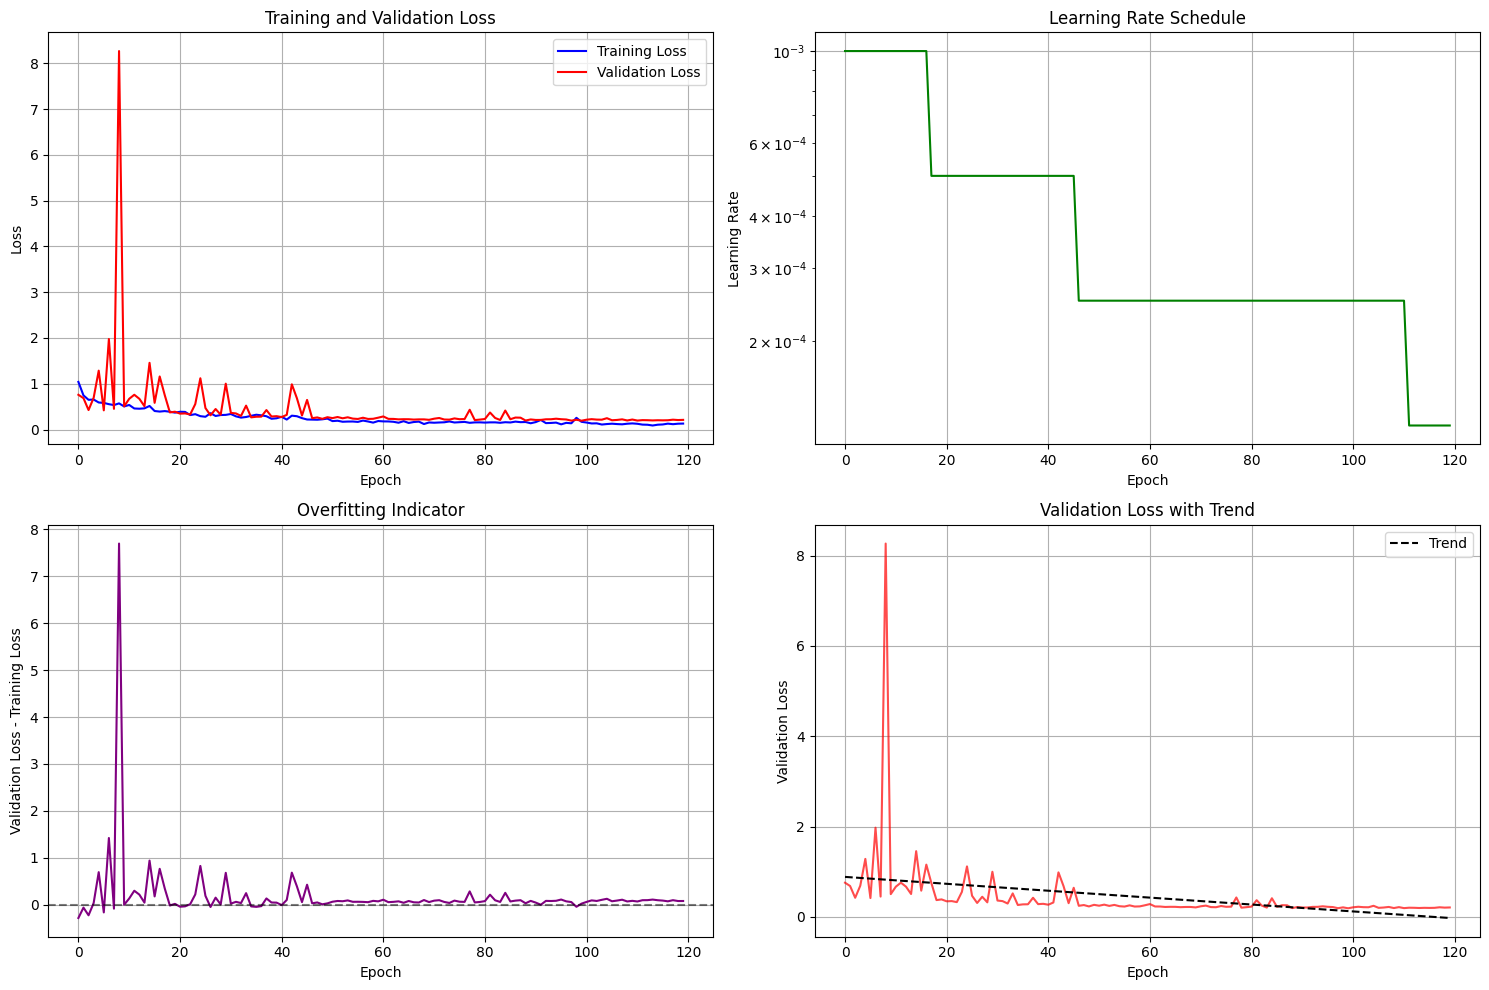

In [14]:
# Evaluate model on test set
print("\nEvaluating model on test set...")
evaluation_results = evaluate_model(
    model=trained_model,
    data_loader=test_loader,
    dataset=train_dataset,  # For normalization parameters
    fpbase_dataset=dataset,
    target_name='ex_max'
)

# Plot training history
plot_training_history(train_losses, val_losses, learning_rates)
